In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'TEP.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2006-06-30,698,-118,579,36,185,323,2,575,332,...,1065,57,0,143,379,224,631,59,-31,56.38
1,2006-12-31,694,-119,575,38,459,302,0,833,336,...,1332,60,0,245,493,85,606,83,-31,56.38
2,2007-06-30,751,-127,624,47,389,359,0,823,432,...,1440,62,0,87,367,127,522,59,-30,56.38
3,2007-12-31,876,-143,734,54,369,390,1,842,510,...,1603,75,0,101,482,136,650,118,-41,56.38
4,2008-06-30,893,-139,754,56,308,437,1,840,517,...,1588,75,77,67,484,98,625,-22,-38,55.69


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
31,2021-12-31,2022-02-11,59.53,3684,0,3684,302,837,1580,0,...,1422,8346,280,2,716,2039,2270,5189,584,-132
32,2022-06-30,2022-07-21,59.71,3946,0,3946,274,756,1642,0,...,1466,8765,242,0,640,2010,2201,5164,616,-151
33,2022-12-31,2023-02-11,59.71,4208,0,4208,371,817,1707,0,...,1345,8864,232,4,884,2288,2021,5192,678,-147
34,2023-06-30,2023-07-21,59.10,3960,0,3960,271,727,1715,0,...,1256,8769,216,2,949,2271,1878,5049,590,-112
35,2023-12-31,2024-02-11,59.10,4385,0,4385,331,882,2132,0,...,1297,11754,334,15,1,2708,3822,7522,785,-121


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
31,2021-12-31,2022-02-11,59.53,3684,0,3684,302,837,1580,0,...,8346,280,2,716,2039,2270,5189,584,-132,0.874514
32,2022-06-30,2022-07-21,59.71,3946,0,3946,274,756,1642,0,...,8765,242,0,640,2010,2201,5164,616,-151,0.938325
33,2022-12-31,2023-02-11,59.71,4208,0,4208,371,817,1707,0,...,8864,232,4,884,2288,2021,5192,678,-147,0.980663
34,2023-06-30,2023-07-21,59.10,3960,0,3960,271,727,1715,0,...,8769,216,2,949,2271,1878,5049,590,-112,0.918362
35,2023-12-31,2024-02-11,59.10,4385,0,4385,331,882,2132,0,...,11754,334,15,1,2708,3822,7522,785,-121,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
31,2021-12-31,2022-02-11,59.53,3684,0,3684,302,837,1580,0,...,8346,280,2,716,2039,2270,5189,584,-132,0.874514
32,2022-06-30,2022-07-21,59.71,3946,0,3946,274,756,1642,0,...,8765,242,0,640,2010,2201,5164,616,-151,0.938325
33,2022-12-31,2023-02-11,59.71,4208,0,4208,371,817,1707,0,...,8864,232,4,884,2288,2021,5192,678,-147,0.980663
34,2023-06-30,2023-07-21,59.10,3960,0,3960,271,727,1715,0,...,8769,216,2,949,2271,1878,5049,590,-112,0.918362
35,2023-12-31,2024-02-11,59.10,4385,0,4385,331,882,2132,0,...,11754,334,15,1,2708,3822,7522,785,-121,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2006-07-24,21.280222,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,0.407512,0.592488,8.643963,8.280702,15.091892,236.0,0.829513,0.051576,0.135211,0.331797
1,2006-07-31,21.853432,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,0.407512,0.592488,8.643963,8.280702,15.091892,236.0,0.829513,0.051576,0.135211,0.331797
2,2006-08-07,21.065273,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,0.407512,0.592488,8.643963,8.280702,15.091892,236.0,0.829513,0.051576,0.135211,0.331797
3,2006-08-14,21.495176,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,0.407512,0.592488,8.643963,8.280702,15.091892,236.0,0.829513,0.051576,0.135211,0.331797
4,2006-08-21,20.850317,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,0.407512,0.592488,8.643963,8.280702,15.091892,236.0,0.829513,0.051576,0.135211,0.331797


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2006-07-24,21.280222,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,236.0,0.829513,0.051576,0.135211,0.331797,8.331798,2.764468,0.429720,0.589462,3.332719
1,2006-07-31,21.853432,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,236.0,0.829513,0.051576,0.135211,0.331797,8.556226,2.838932,0.441295,0.601037,3.422490
2,2006-08-07,21.065273,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,236.0,0.829513,0.051576,0.135211,0.331797,8.247640,2.736544,0.425380,0.585122,3.299056
3,2006-08-14,21.495176,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,236.0,0.829513,0.051576,0.135211,0.331797,8.415959,2.792392,0.434061,0.593803,3.366383
4,2006-08-21,20.850317,2006-06-30,698.0,2.554097,7.697765,56.38,360.0,6.385243,185.0,...,236.0,0.829513,0.051576,0.135211,0.331797,8.163478,2.708620,0.421039,0.580781,3.265391


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

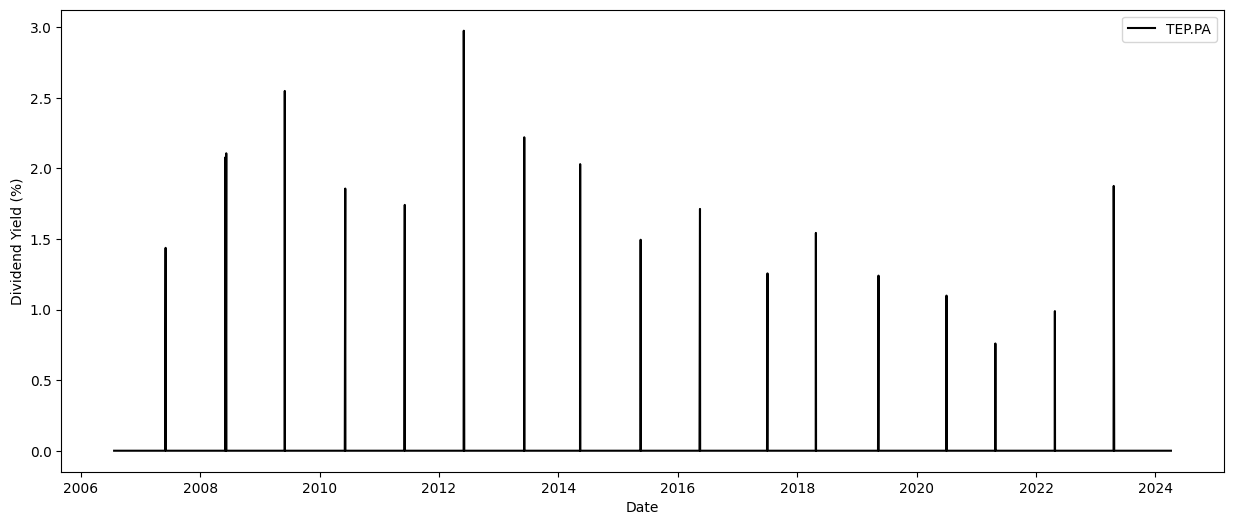

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.640825
share_price      1.000000
Name: share_price, dtype: float64


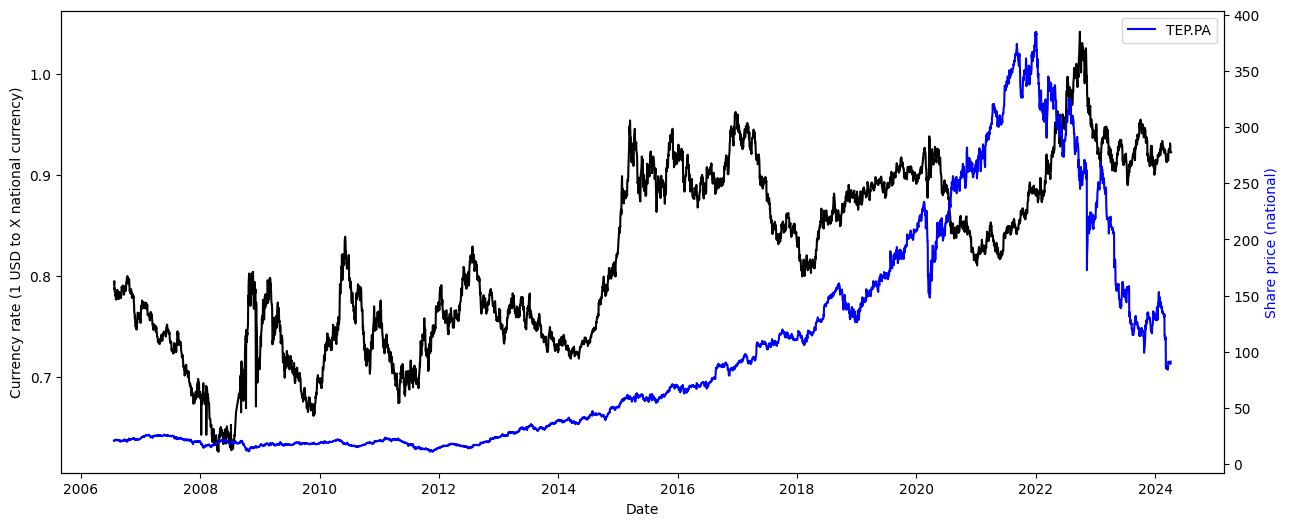

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

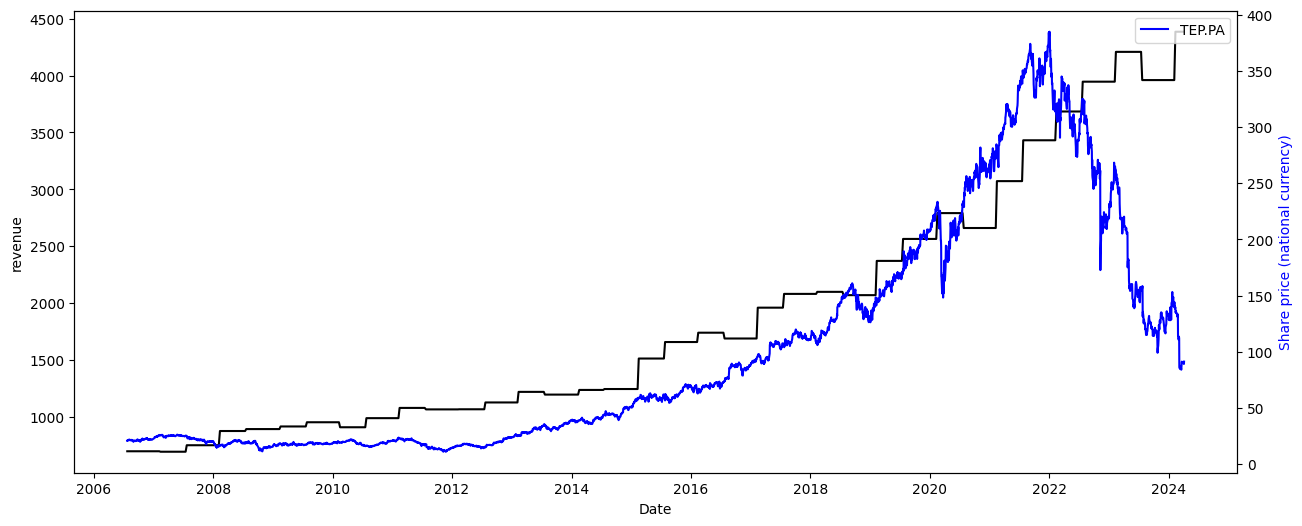

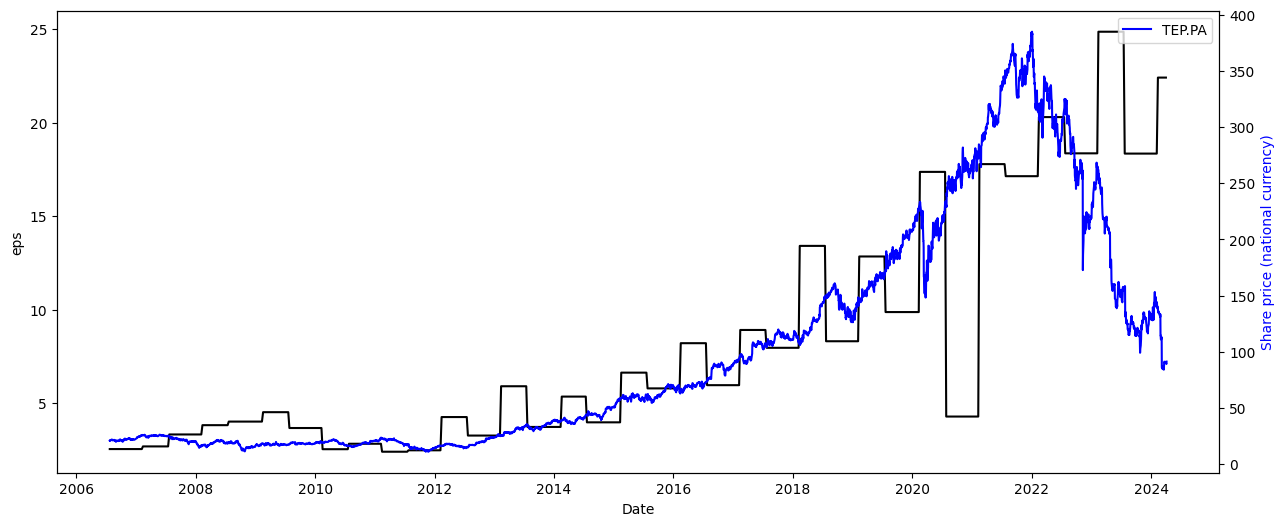

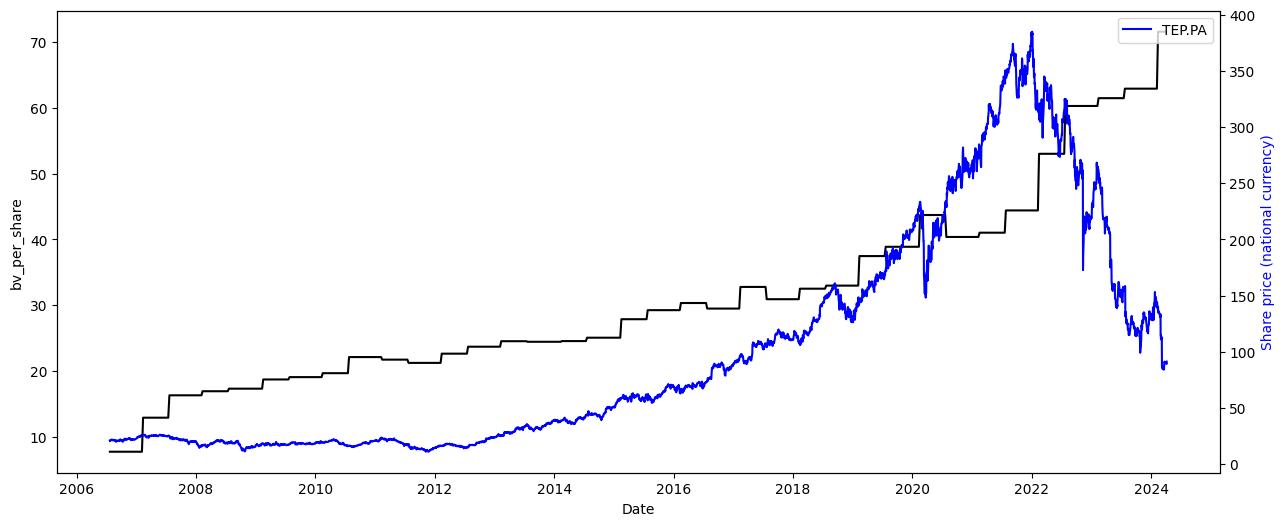

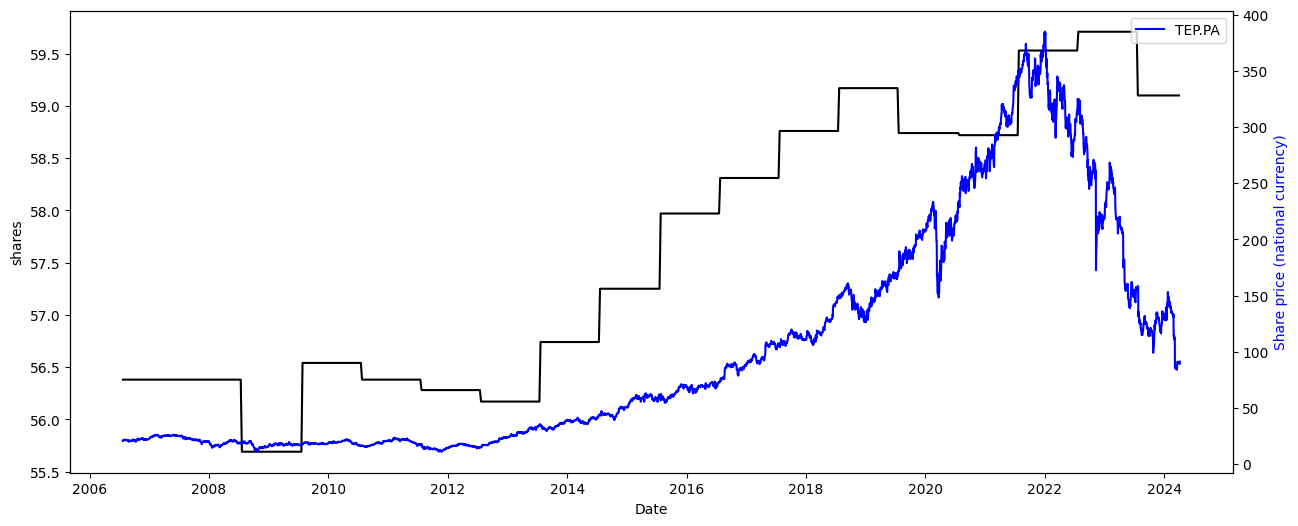

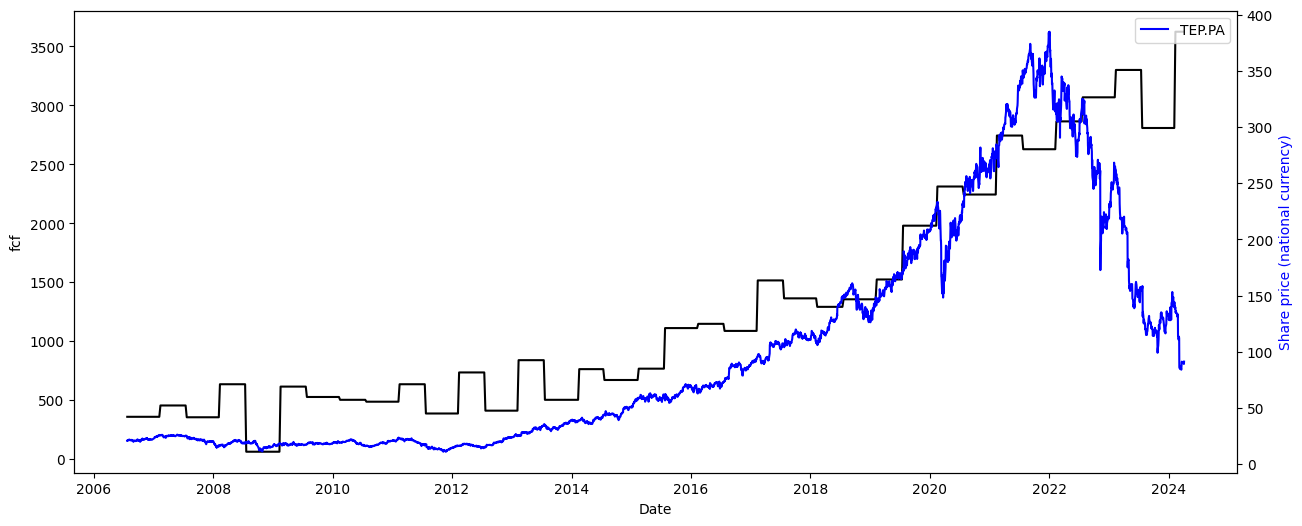

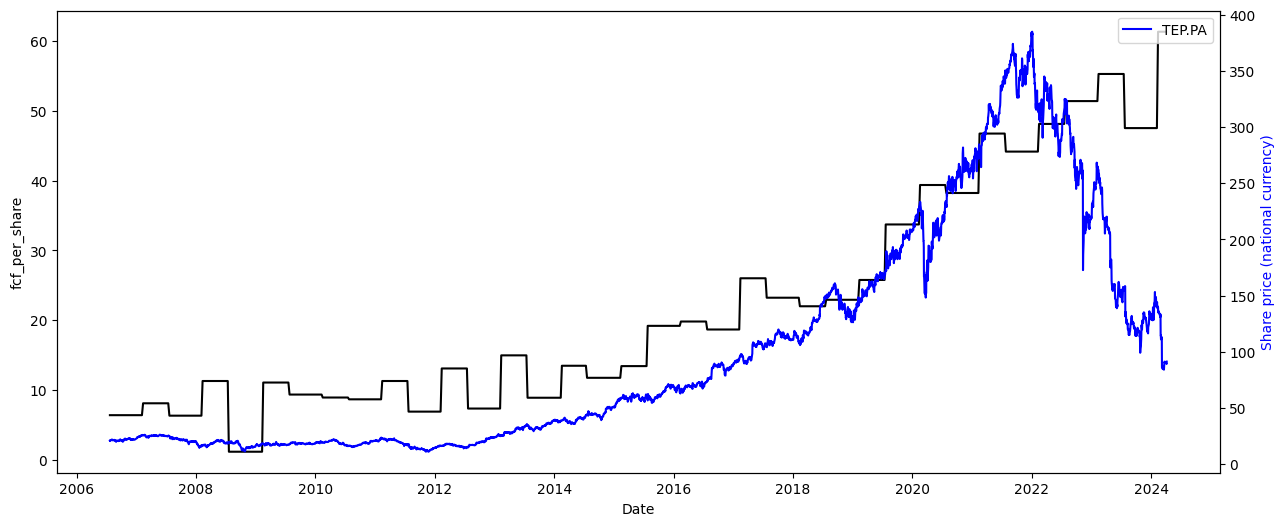

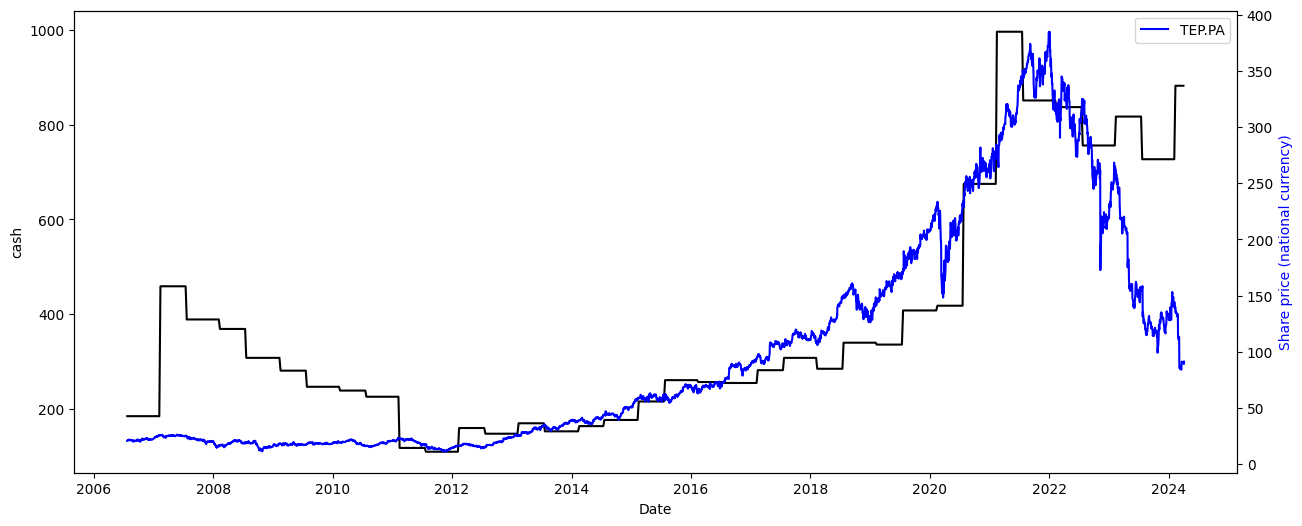

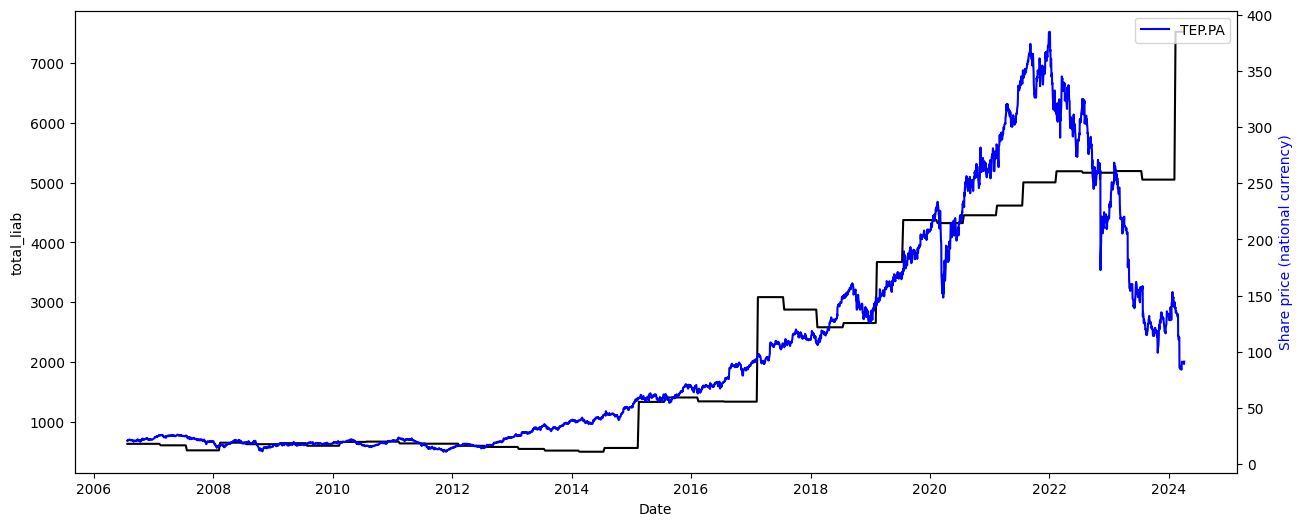

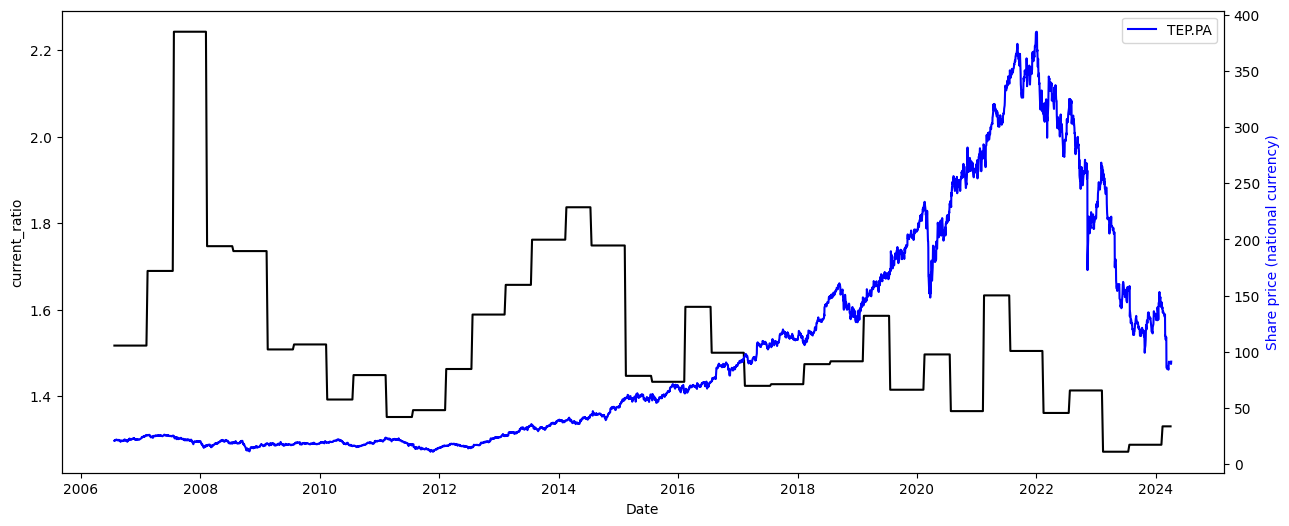

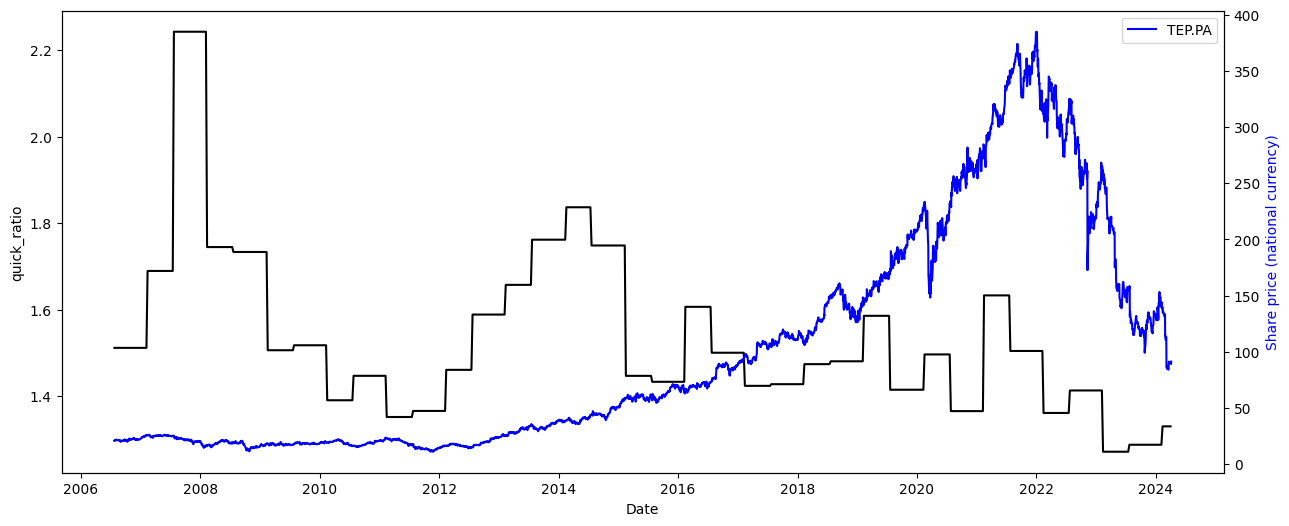

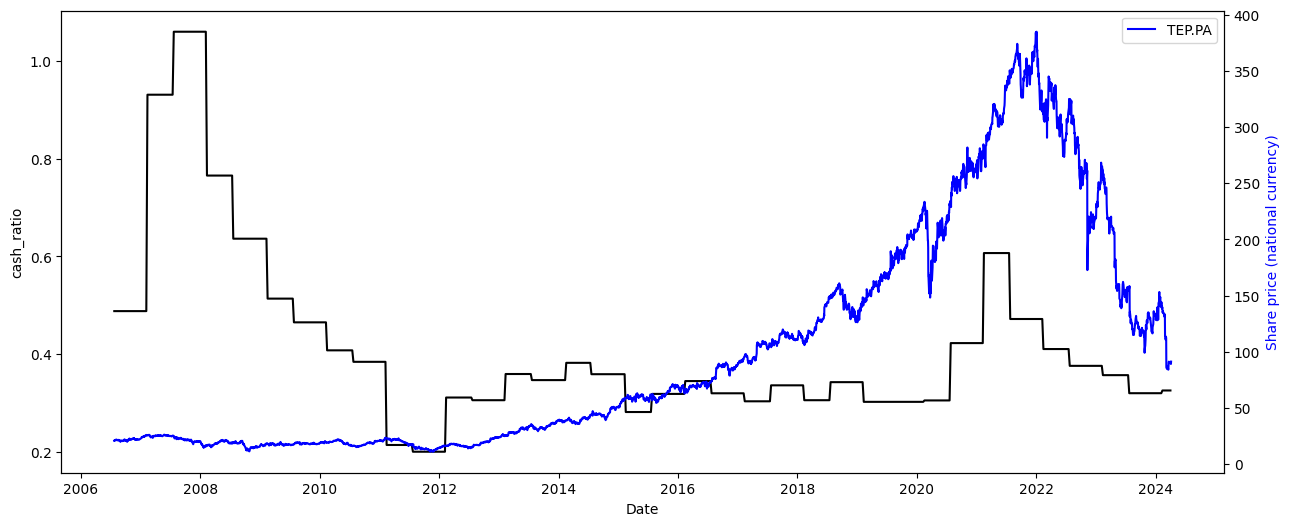

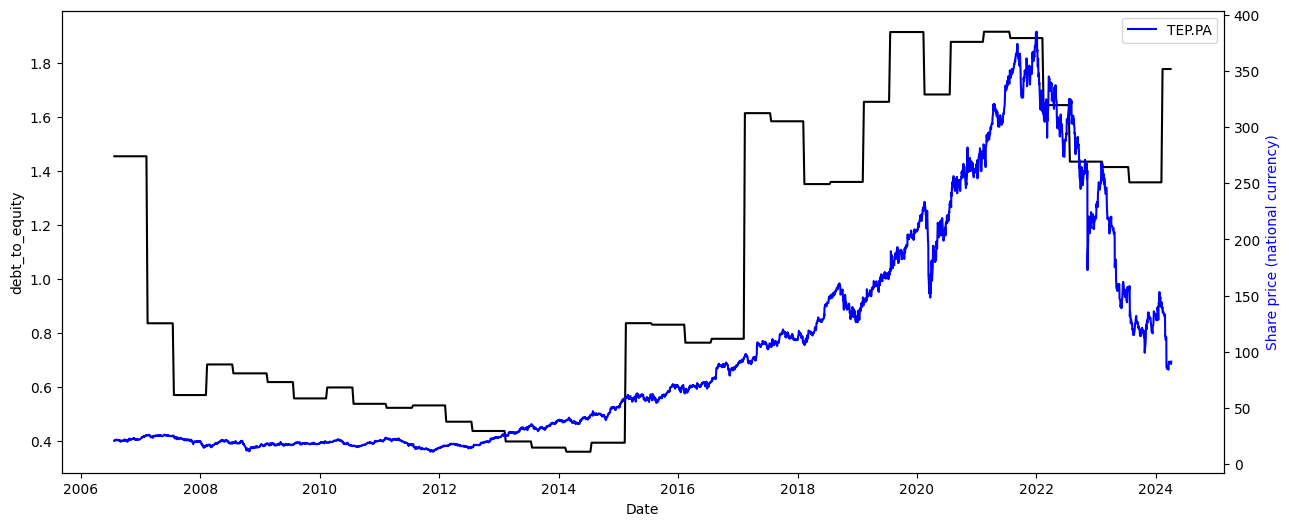

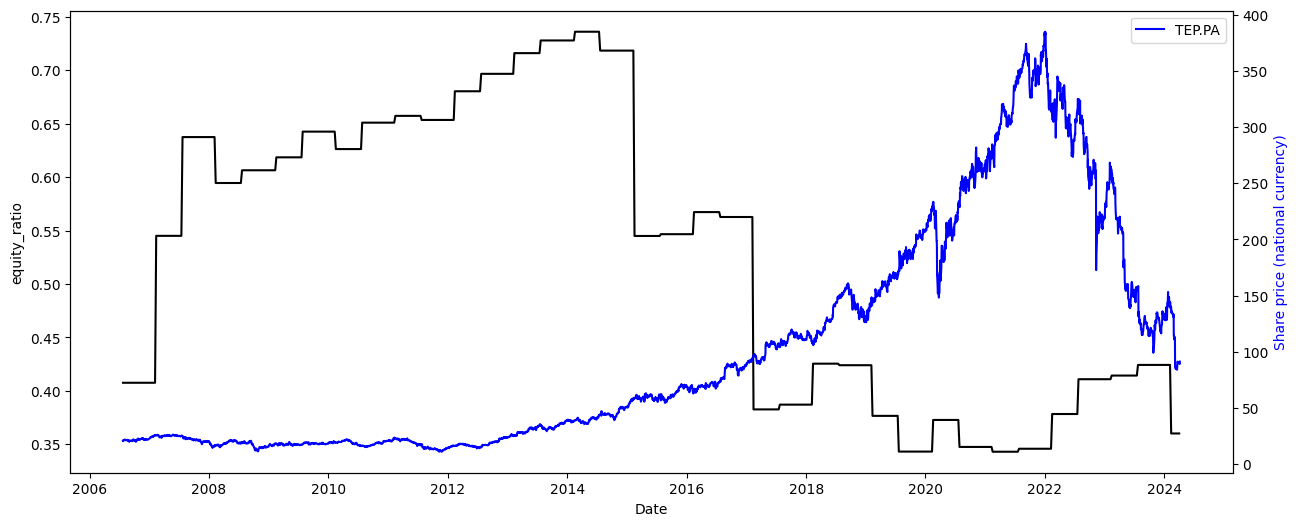

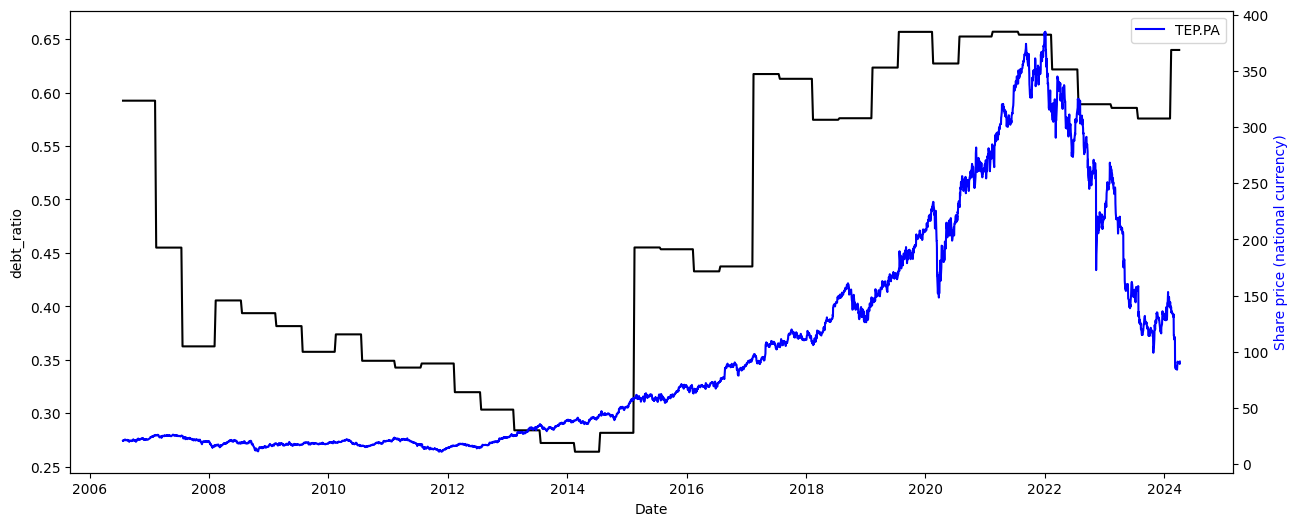

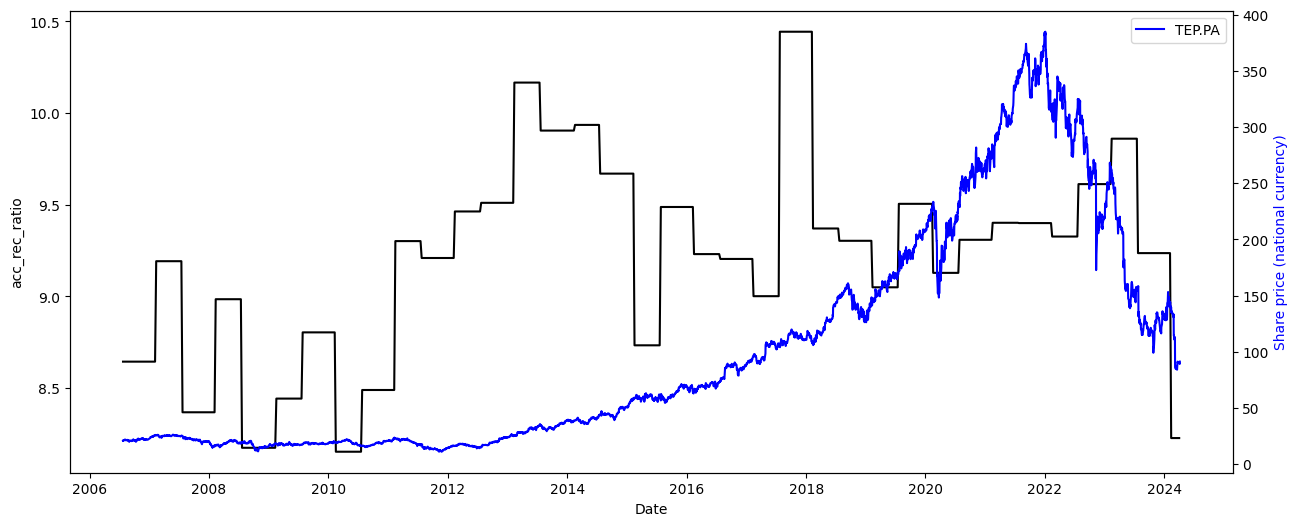

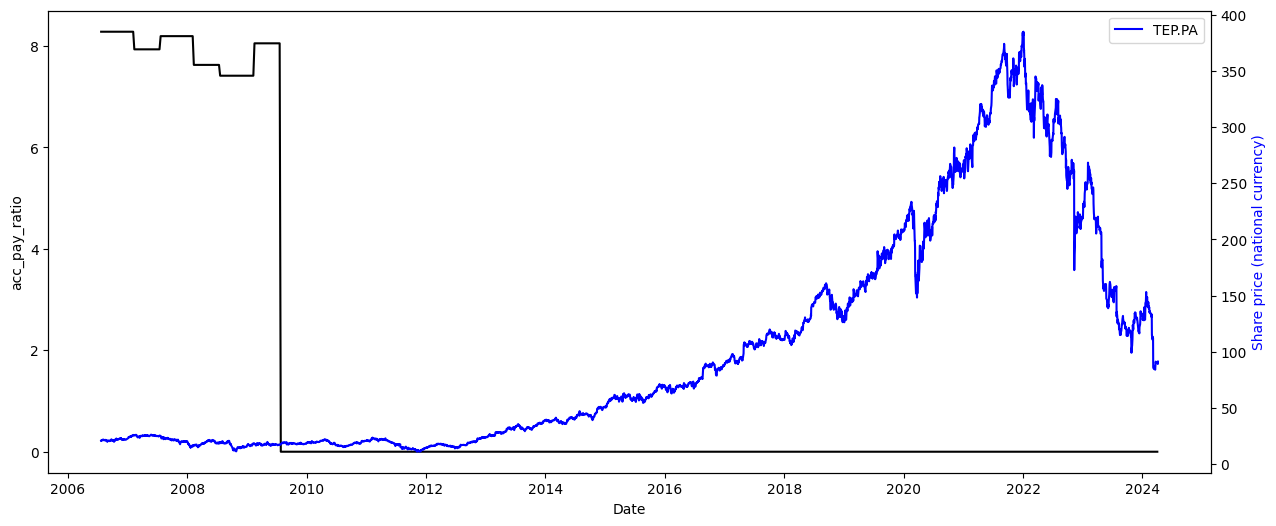

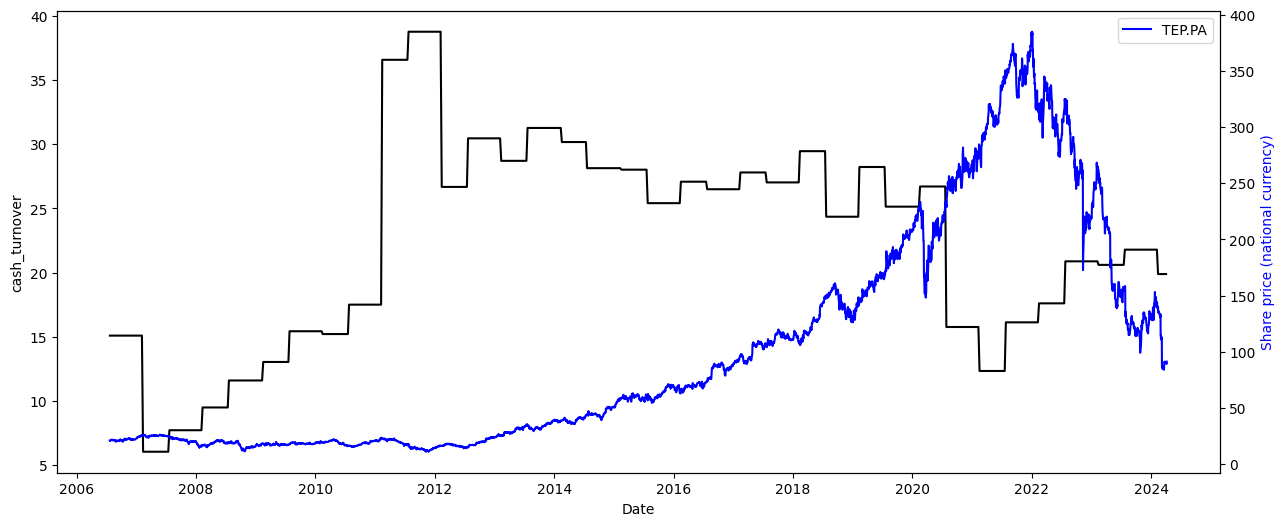

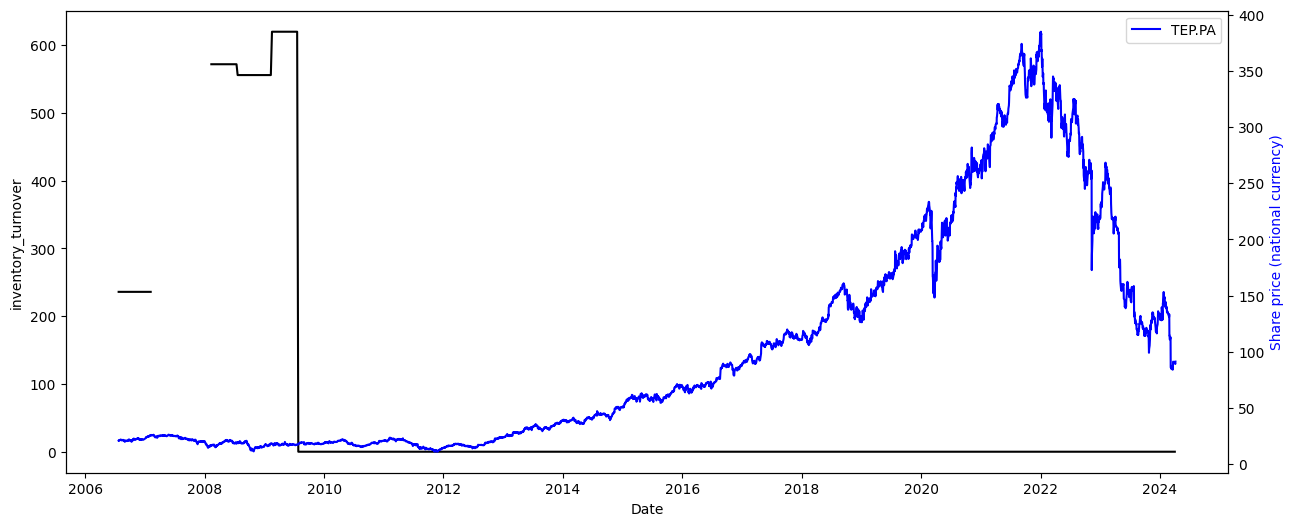

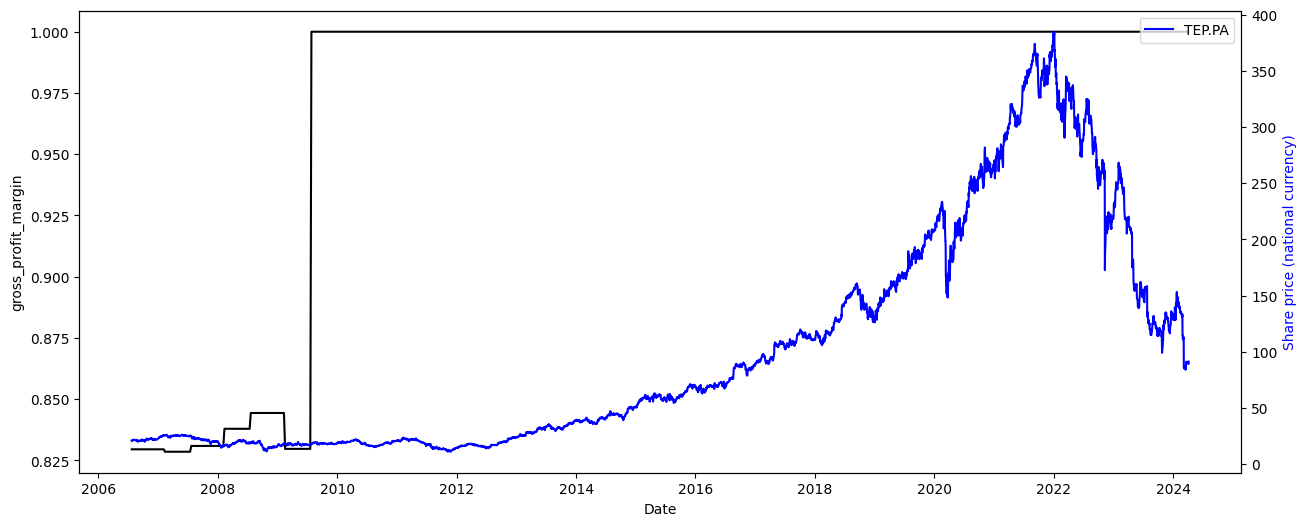

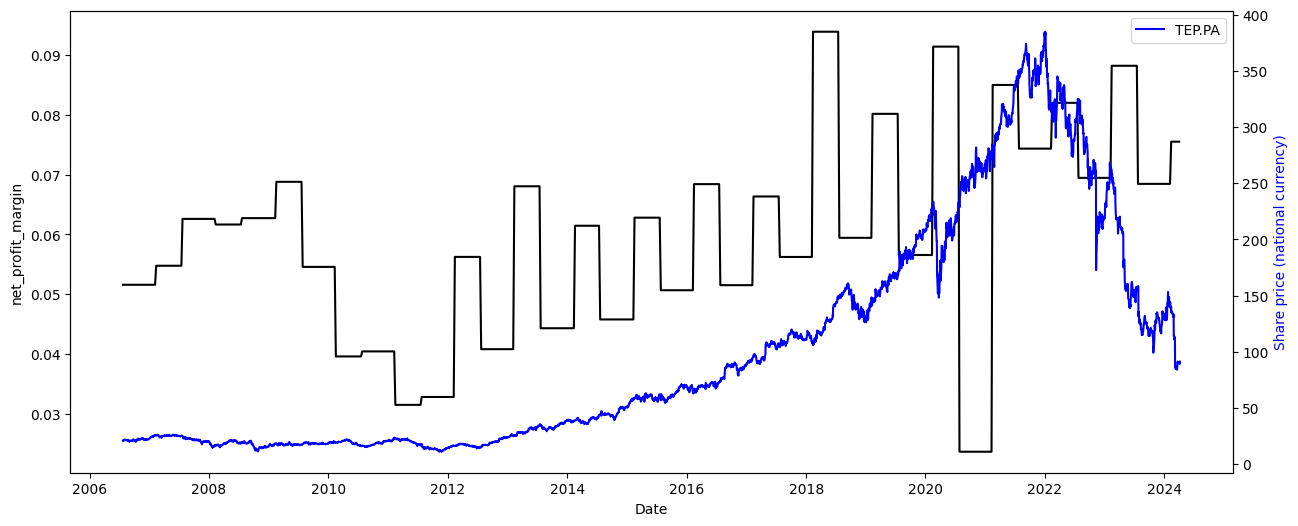

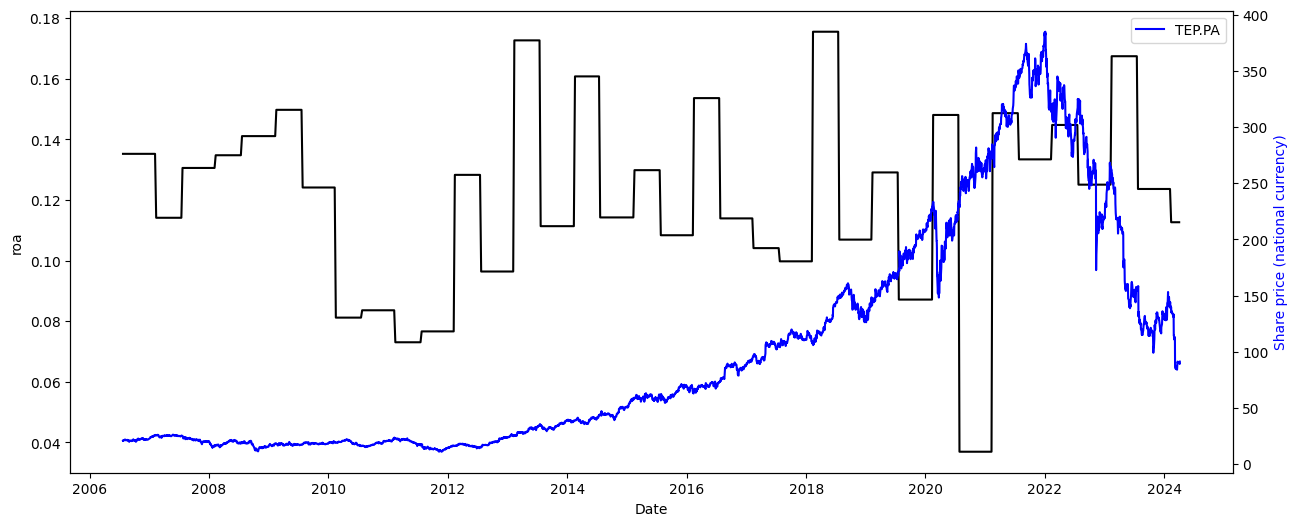

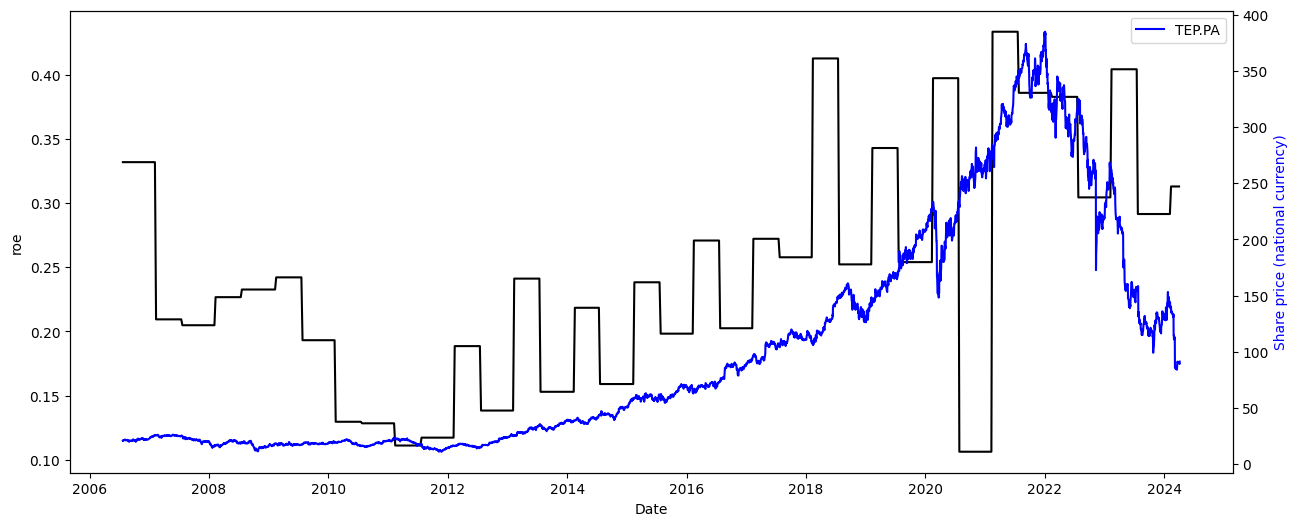

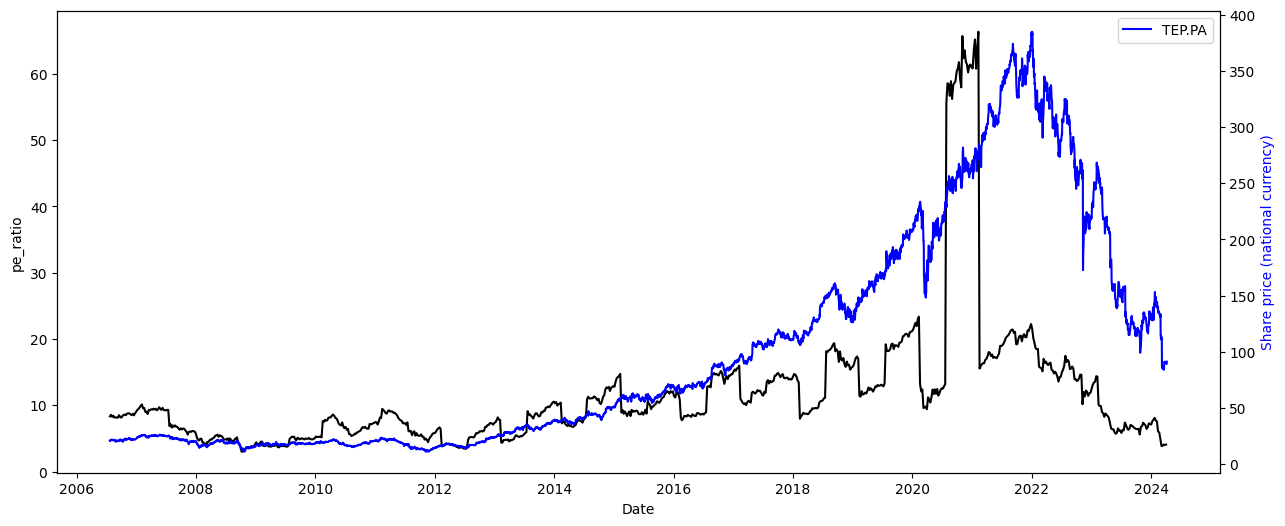

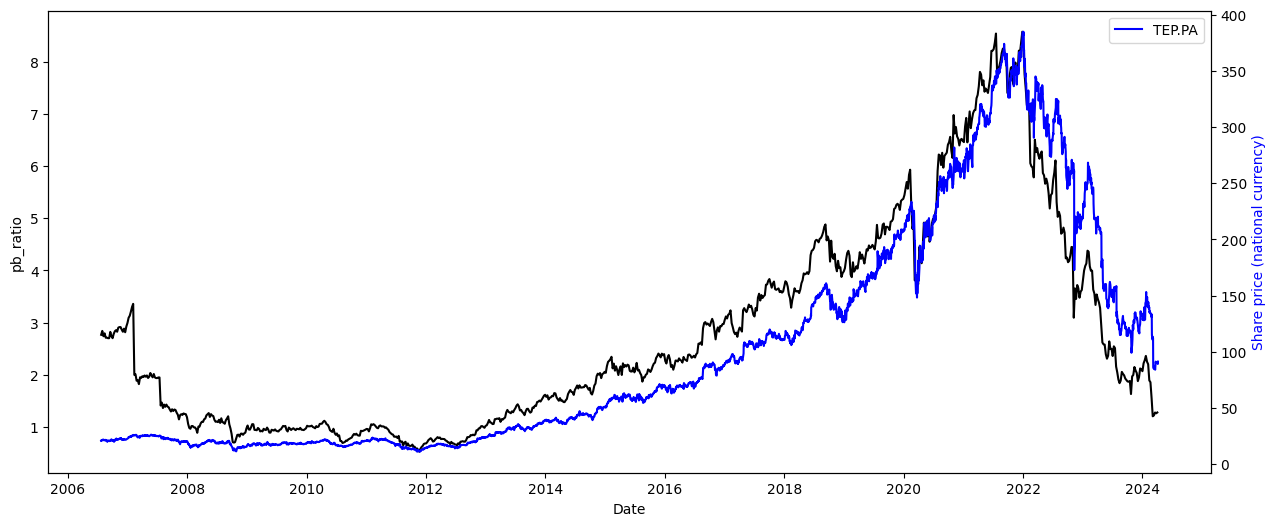

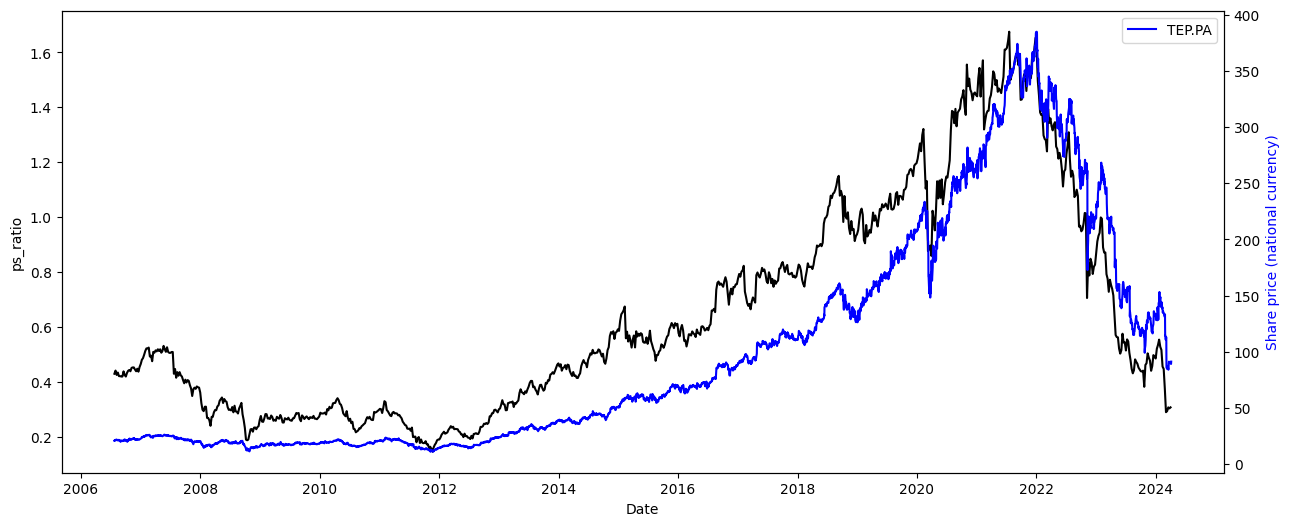

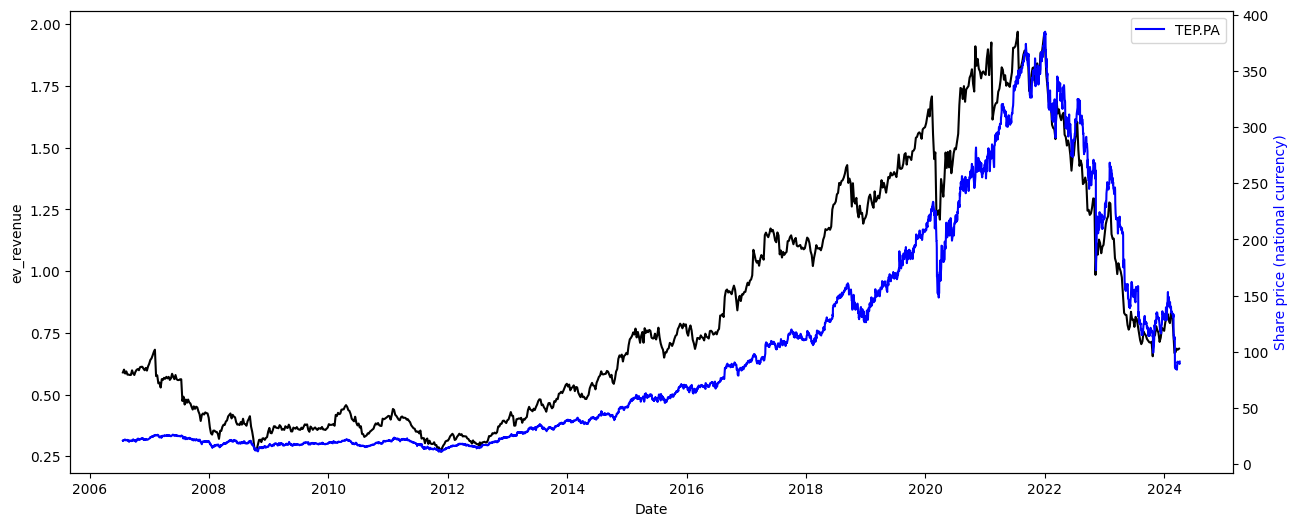

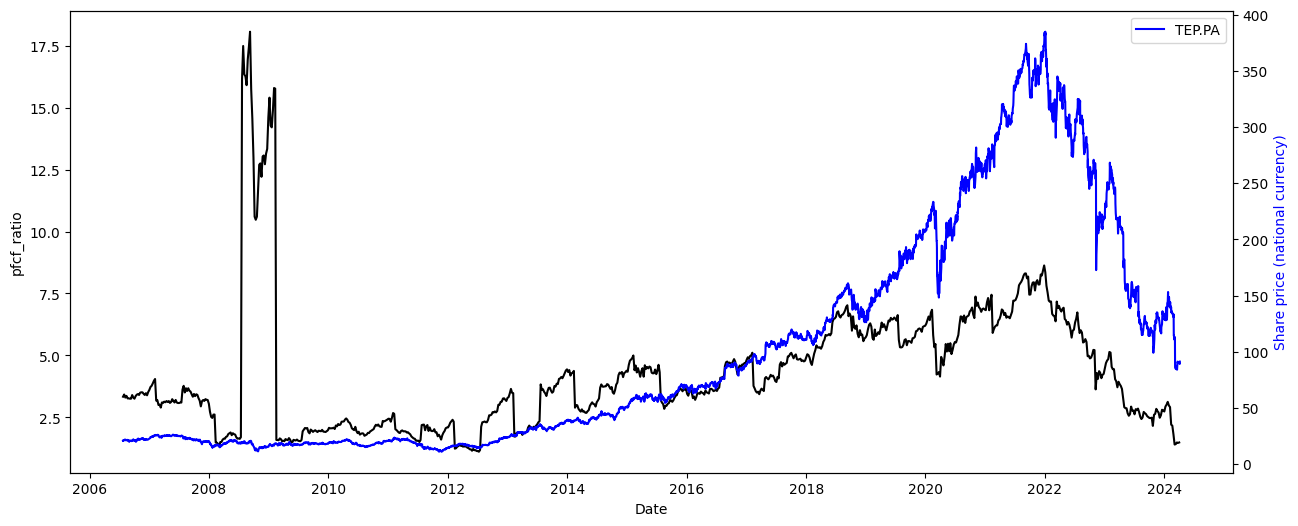

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

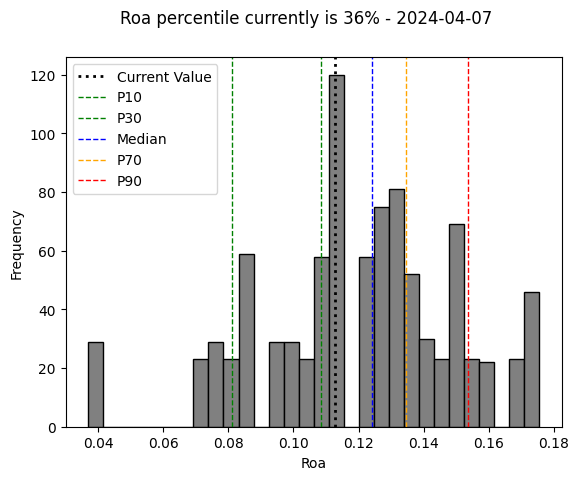

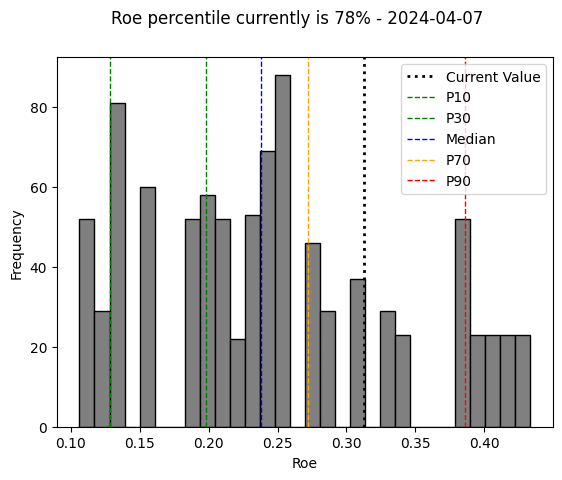

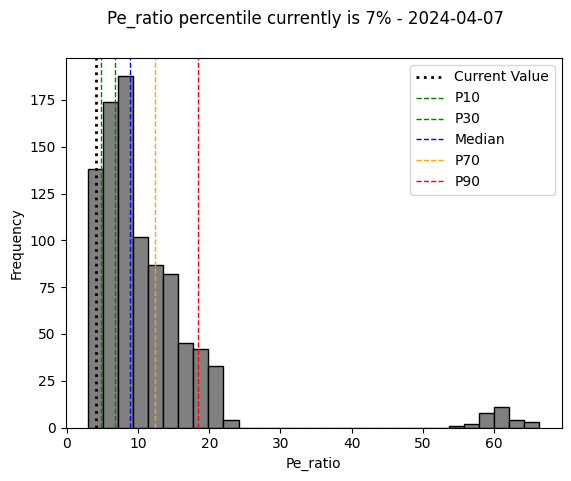

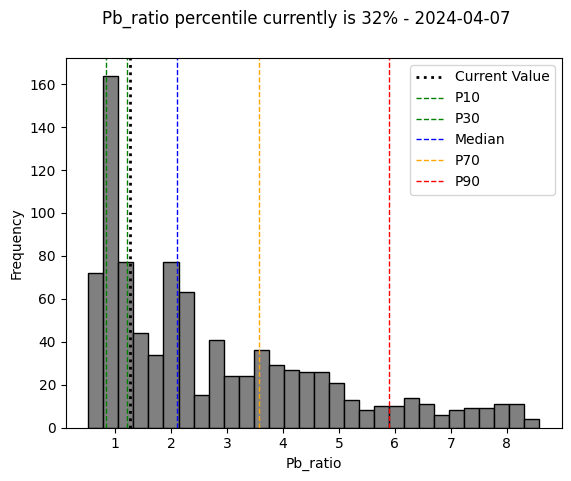

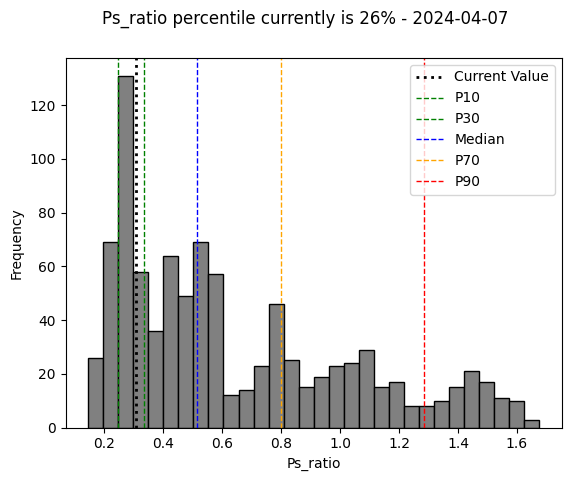

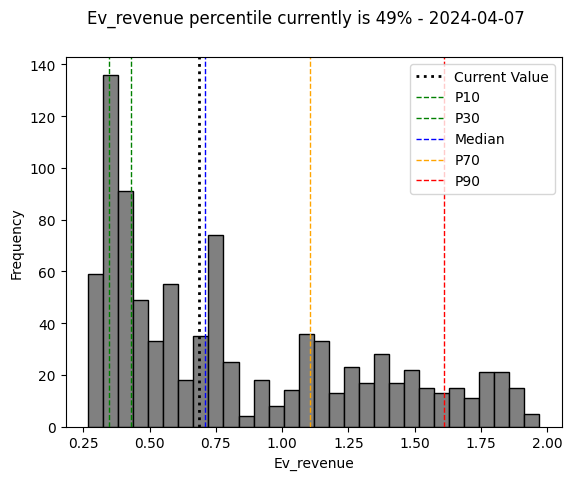

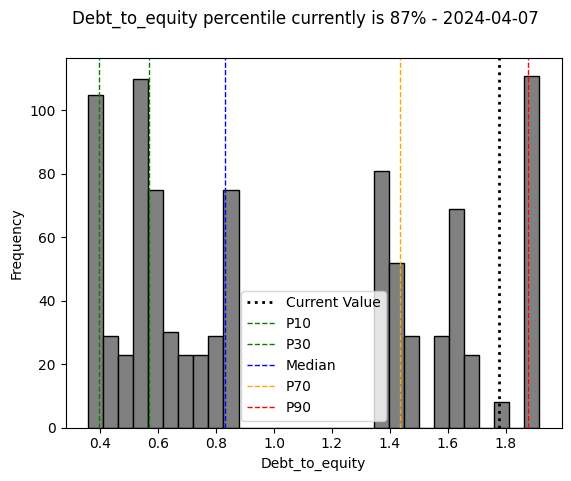

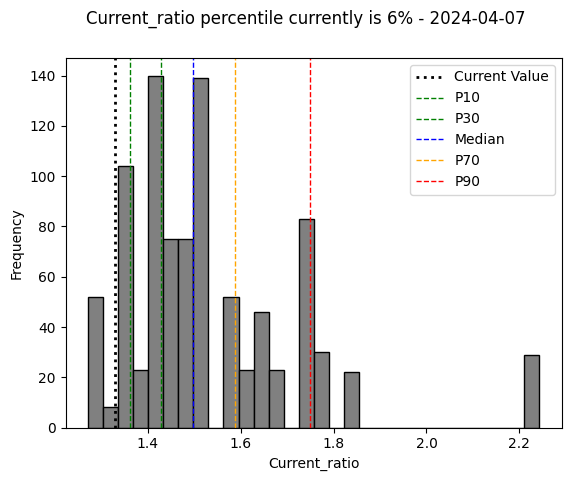

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.694275,-0.493657,0.015834,-0.015338,-0.037058,-0.023304,0.295413
roe,0.694275,1.000000,-0.048570,0.607720,0.557458,0.580791,0.674758,-0.131382
pe_ratio,-0.493657,-0.048570,1.000000,0.681028,0.715148,0.702931,0.560242,-0.234036
pb_ratio,0.015834,0.607720,0.681028,1.000000,0.987731,0.979011,0.868559,-0.247159
ps_ratio,-0.015338,0.557458,0.715148,0.987731,1.000000,0.990641,0.841904,-0.227550
ev_revenue,-0.037058,0.580791,0.702931,0.979011,0.990641,1.000000,0.894614,-0.309569
debt_to_equity,-0.023304,0.674758,0.560242,0.868559,0.841904,0.894614,1.000000,-0.429664
current_ratio,0.295413,-0.131382,-0.234036,-0.247159,-0.227550,-0.309569,-0.429664,1.000000


8 timestemos have been found!


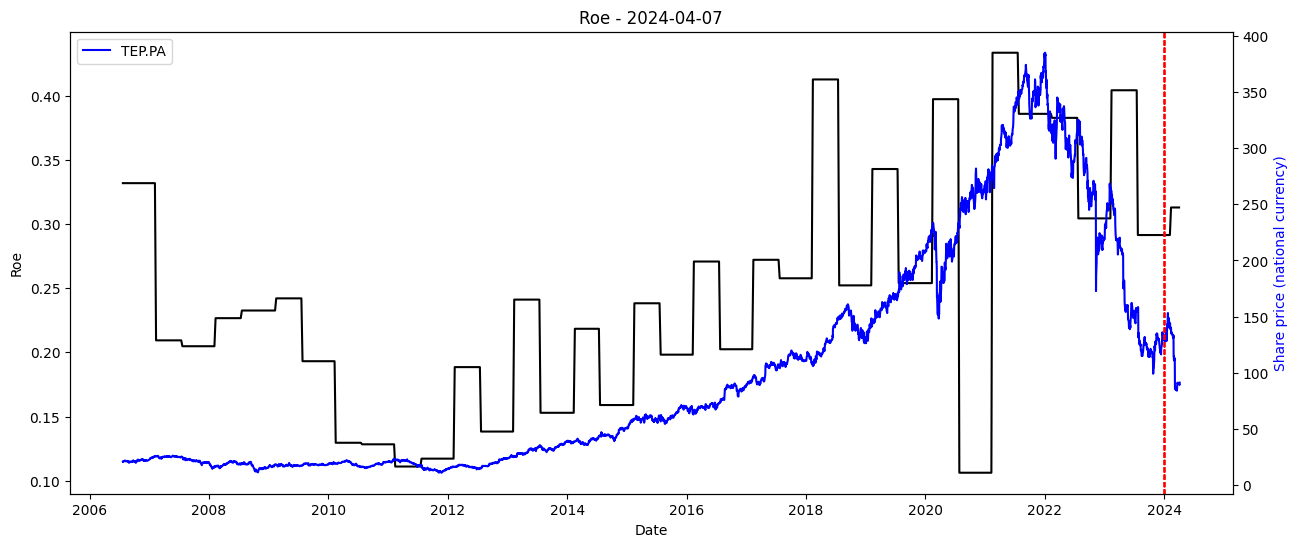

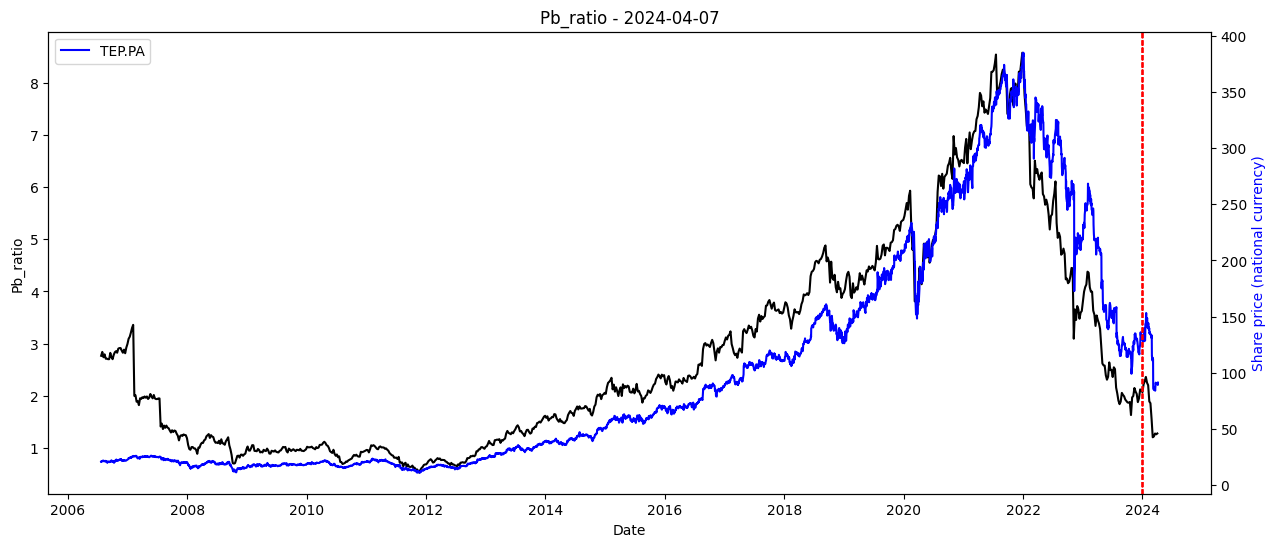

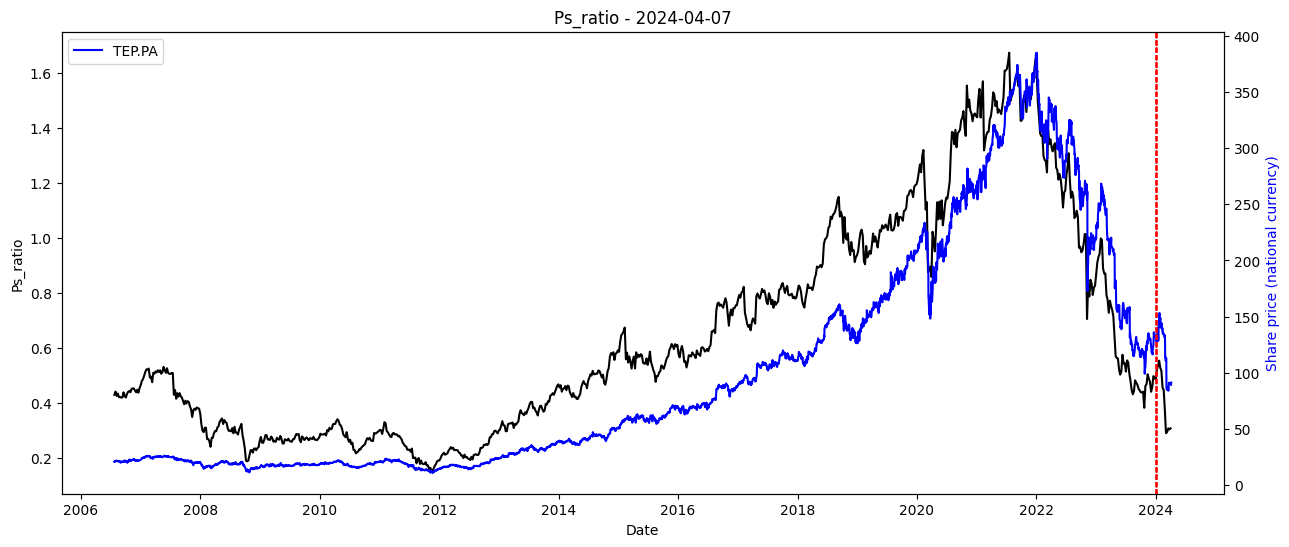

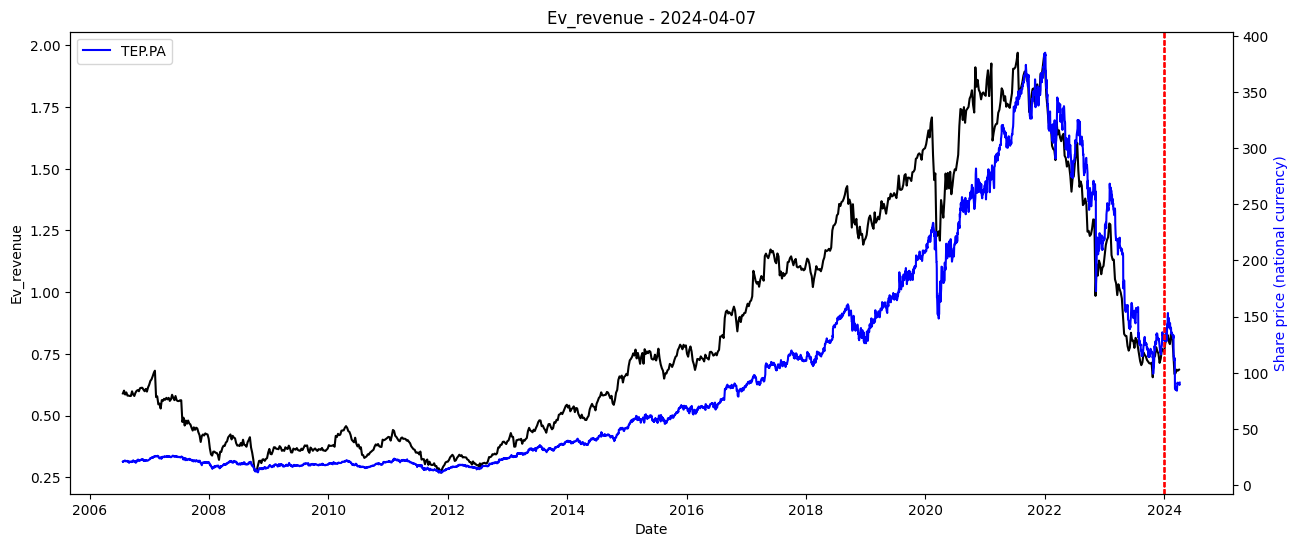

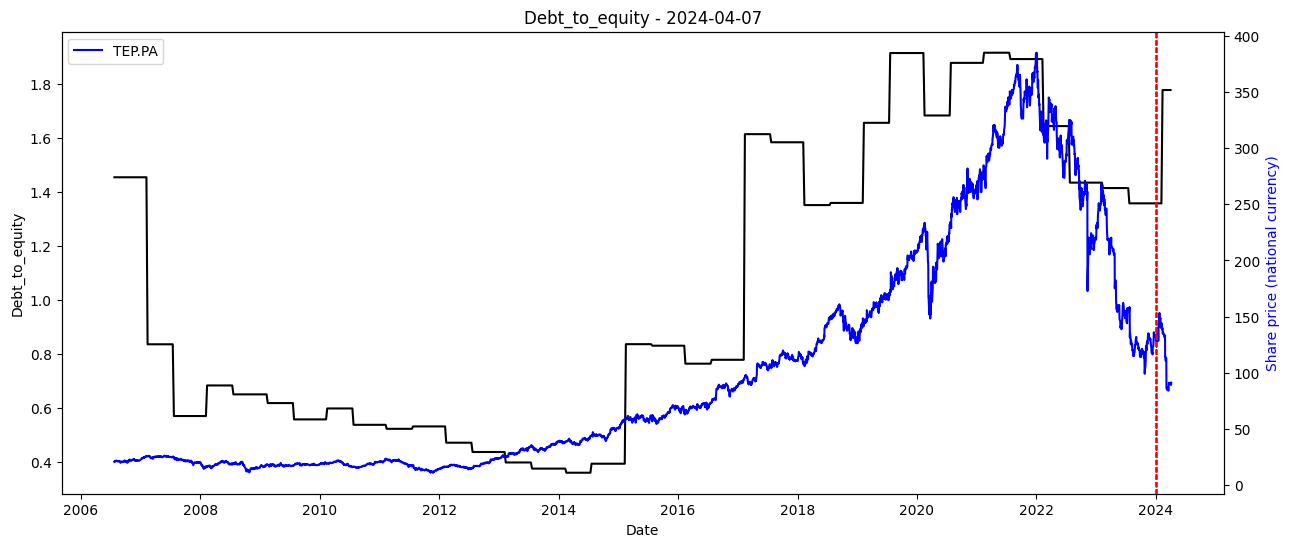

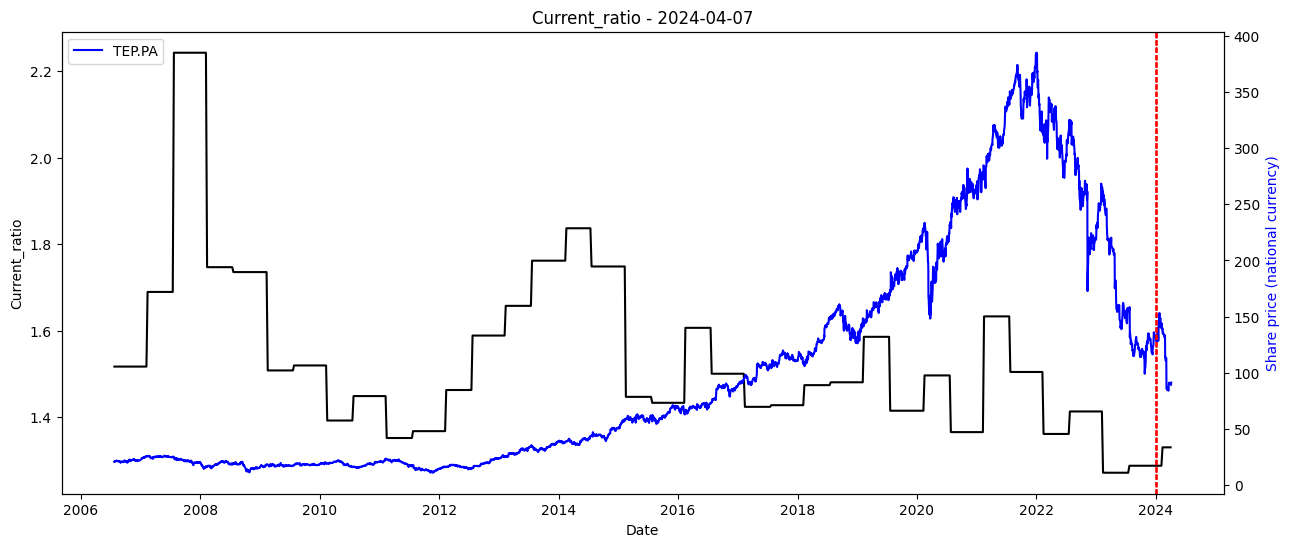

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )

In [22]:
merged_nat_curr.tail()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
919,2024-03-04,86.000000,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,3.838822,1.200992,0.289772,0.668335,1.402483
920,2024-03-11,87.160004,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,3.890601,1.217192,0.293681,0.672244,1.421401
921,2024-03-18,91.199997,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,4.070936,1.273611,0.307293,0.685856,1.487285
922,2024-03-25,90.080002,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,4.020943,1.257970,0.303519,0.682083,1.469020
923,2024-04-01,91.220001,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,4.071829,1.273890,0.307360,0.685924,1.487611
